## Stage 4 Only, Tau Sweep Prev Violaton

**Goal:** Sweep over taus for prev violation regressor with only a subset of animals that were performing well in stage 4.

An important analysis here is to see if tau values change much for these animals. This will inform the decision to create the full dataset with violations for all trials and what to expect form that dataset if so.

In [23]:
import pandas as pd
import seaborn as sns
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import sys
[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]

from experiment_tau_sweep import ExperimentTauSweep
from design_matrix_generator import DesignMatrixGeneratorFilteredHistory
from multiclass_logistic_regression import MultiClassLogisticRegression
from model_visualizer import ModelVisualizerTauSweep

sns.set_context("talk")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
stg4_animals = [
    "W051",
    "W060",
    "W065",
    "W068",
    "W072",
    "W073",
    "W074",
    "W075",
    "W078",
    "W080",
    "W082",
    "W083",
    "W088",
    "W089",
]

In [11]:
params = {
    "animals": stg4_animals,
    "sigmas": [0.07, 0.13, 0.25, 0.5, 1, 2, 4, 8, 16],
    "taus": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "random_state": 47,
    "eval_train": True,
    "tau_sweep": {
        "prev_violation": True,
    },
    "model_config": {
        "tau_sweep_prev_choice": {
            "model_class": MultiClassLogisticRegression,
            "model_type": "multi",
            "design_matrix_generator": DesignMatrixGeneratorFilteredHistory,
            "design_matrix_generator_args": {"interaction_pairs": None},
        }
    },
}

In [47]:
experiment = ExperimentTauSweep(params)

experiment.run(min_training_stage=4)
experiment.save(file_name="2024_01_17_stg_4_tau_sweep_prev_violations.pkl")

returning viol data for ['W051', 'W060', 'W065', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W082', 'W083', 'W088', 'W089']

 >>>> evaluating animal W051 sweeping taus of prev_violation <<<<

 ***** evaluating tau 1, sigma 0.07 *****
Optimization terminated successfully.
         Current function value: 37337.778319
         Iterations: 26
         Function evaluations: 34
         Gradient evaluations: 34

 ***** evaluating tau 1, sigma 0.13 *****
Optimization terminated successfully.
         Current function value: 37146.478553
         Iterations: 24
         Function evaluations: 33
         Gradient evaluations: 33

 ***** evaluating tau 1, sigma 0.25 *****
Optimization terminated successfully.
         Current function value: 37079.024781
         Iterations: 24
         Function evaluations: 33
         Gradient evaluations: 33

 ***** evaluating tau 1, sigma 0.5 *****
Optimization terminated successfully.
         Current function value: 37059.208173
         Iter

## Visualize Results

In [48]:
mv = ModelVisualizerTauSweep(experiment)

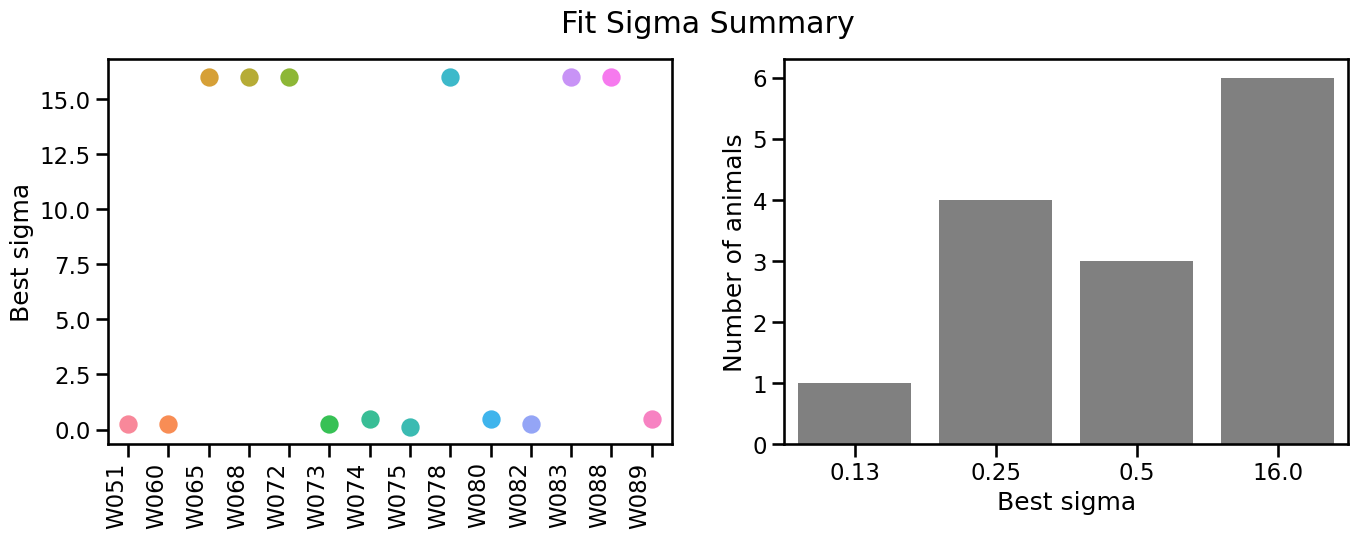

In [49]:
mv.plot_sigma_summary()

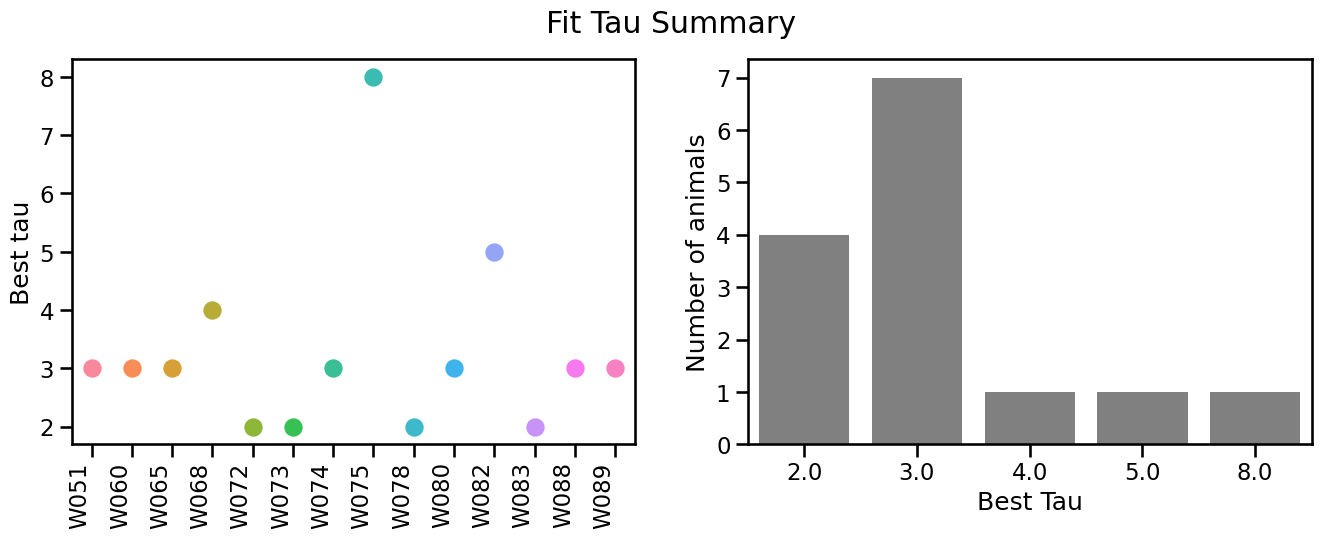

In [50]:
mv.plot_tau_summary()

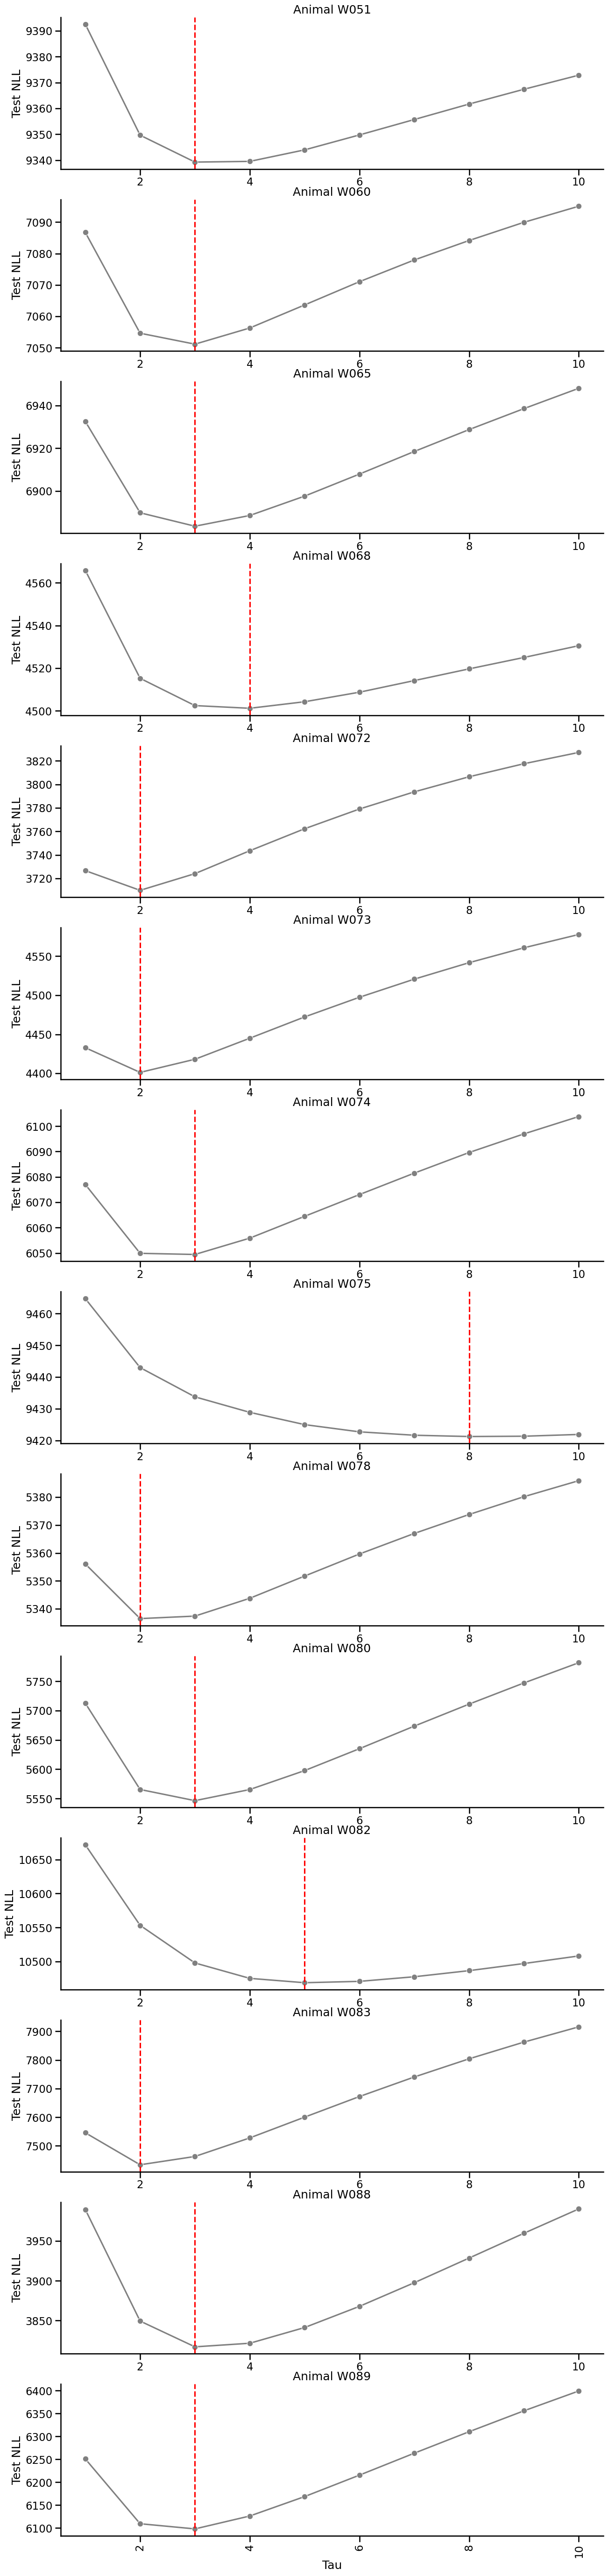

In [51]:
mv.plot_nll_over_taus_by_animal(group="tau", color="gray")

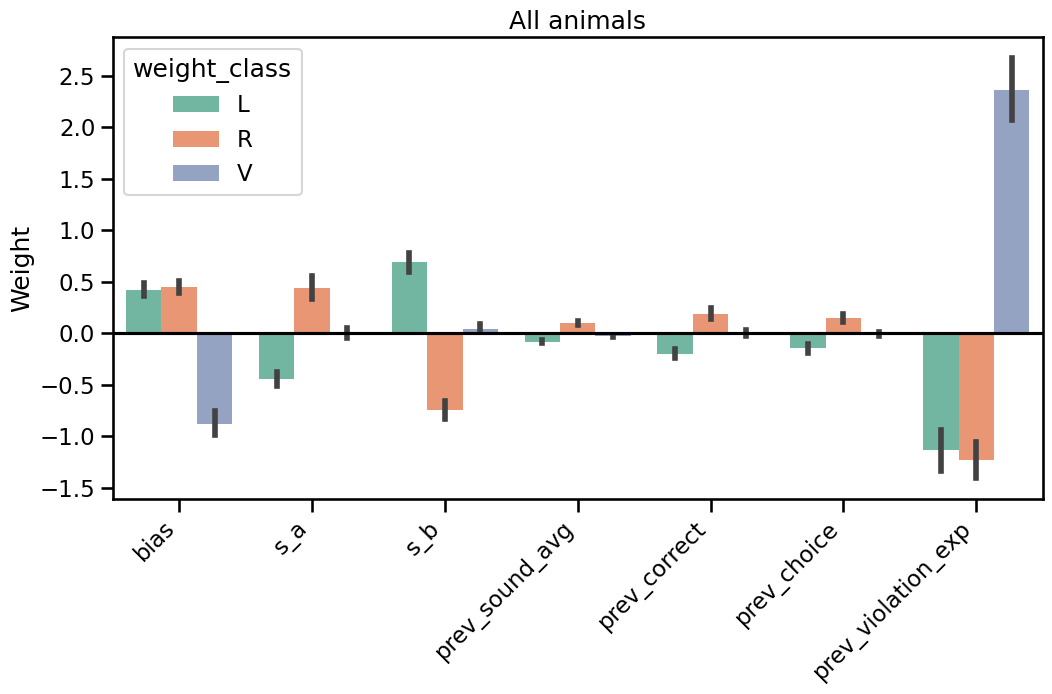

In [52]:
mv.plot_weights_summary(palette="Set2")

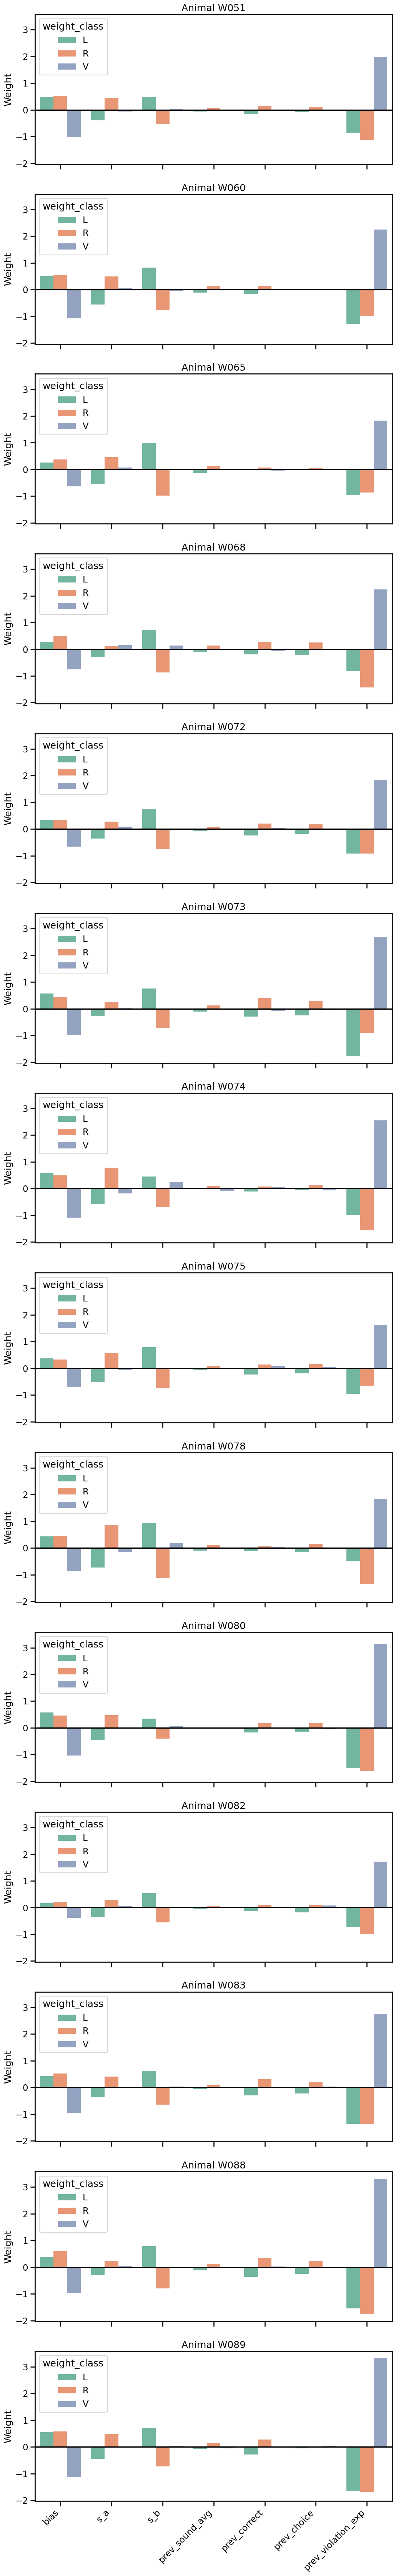

In [53]:
mv.plot_weights_by_animal(palette="Set2")

In [54]:
from fitting_utils import get_taus_df

df = mv.find_best_fit(group="animal_id")

old_taus_df = get_taus_df()
old_taus_df.rename(
    columns={"prev_violation_tau": "prev_violation_tau_old"}, inplace=True
)
merged_taus = pd.merge(
    df[["animal_id", "prev_violation_tau"]], old_taus_df, on="animal_id", how="left"
)

In [62]:
merged_taus

,animal_id,prev_violation_tau,prev_violation_tau_old
0,W051,3.0,6
1,W060,3.0,4
2,W065,3.0,3
3,W068,4.0,4
4,W072,2.0,2
5,W073,2.0,2
6,W074,3.0,4
7,W075,8.0,6
8,W078,2.0,2
9,W080,3.0,3


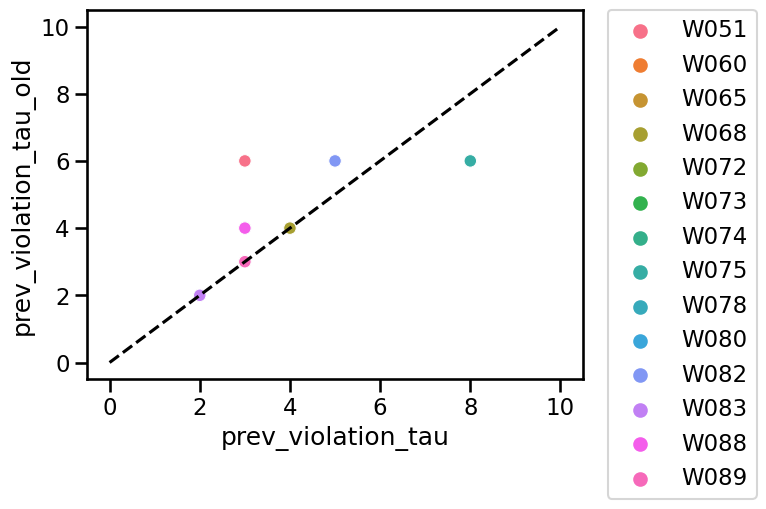

In [72]:
sns.scatterplot(
    data=merged_taus,
    hue="animal_id",
    x="prev_violation_tau",
    y="prev_violation_tau_old",
)

# plot unity line
x = np.linspace(0, 10, 100)
y = x
plt.plot(x, y, color="black", linestyle="--")

# legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [65]:
melted_df = merged_taus.melt(id_vars="animal_id", var_name="tau_type", value_name="tau")

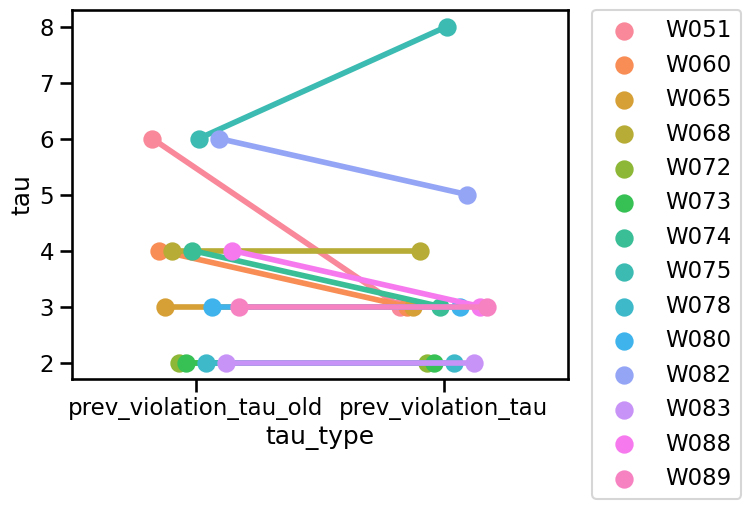

In [70]:
sns.pointplot(
    data=melted_df,
    x="tau_type",
    y="tau",
    order=["prev_violation_tau_old", "prev_violation_tau"],
    hue="animal_id",
    dodge=True,
)

# move legend out
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

Text(0.5, 1.0, 'stg 3 & 4 fit')

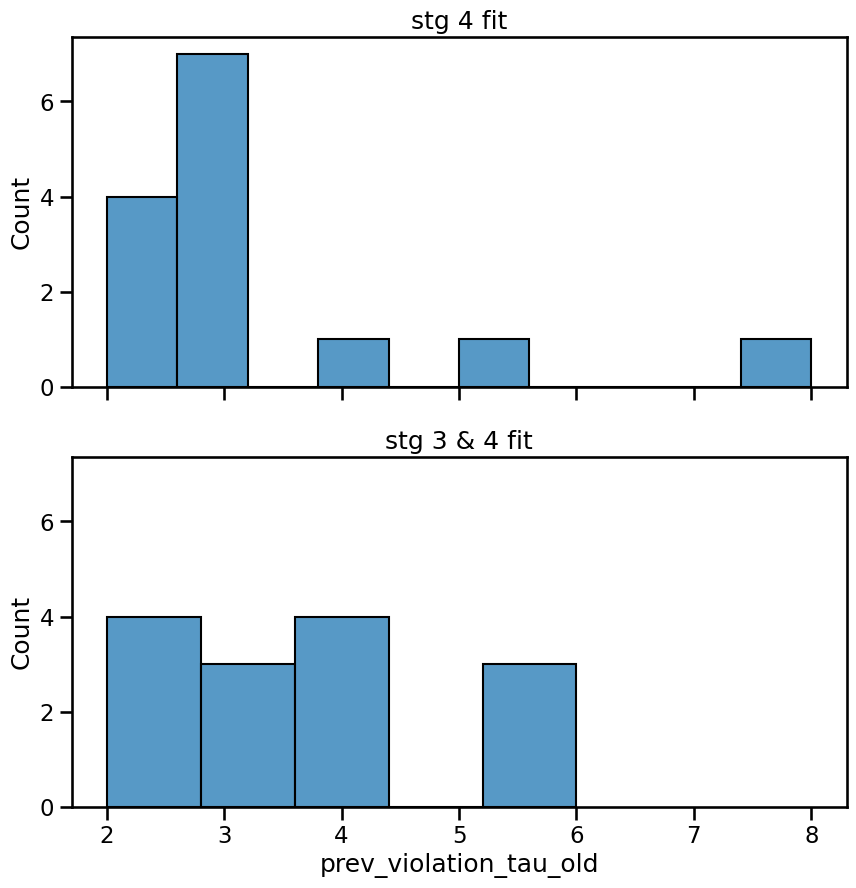

In [58]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True, sharey=True)
sns.histplot(data=merged_taus, x="prev_violation_tau", ax=ax[0])
ax[0].set_title("stg 4 fit")
sns.histplot(data=merged_taus, x="prev_violation_tau_old", ax=ax[1])
ax[1].set_title("stg 3 & 4 fit")

**Summary**: half the animals stay the same (7), half the animals change (7). Mostly getting to have shorter taus, although one is longer (W075). The general range stays the same though. It will be of interest to see how this changes when comparing models.

In [81]:
merged_taus.to_csv(
    "/Users/jessbreda/Desktop/github/animal-learning/data/results/tau_df_stg_4.csv",
    index=False,
)